In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

In [ ]:
# @title Data_preparation
dx   = pd.read_csv('hosp/diagnoses_icd.csv')
adm  = pd.read_csv('hosp/admissions.csv', parse_dates=['admittime'])
meta = pd.read_csv('hosp/d_icd_diagnoses.csv')
admissions_number = dx.groupby(by='subject_id').apply(lambda x: x['hadm_id'].nunique())
icds_number = dx.groupby(by='subject_id').apply(lambda x: x['icd_code'].count())

# merge dx → attach each diagnosis to its admission time
dx = dx.merge(adm[['hadm_id','admittime', 'dischtime', 'admission_type', 'admission_location', 'discharge_location', 'race', 'hospital_expire_flag']], on='hadm_id')
dx = dx.sort_values(['subject_id','admittime'])

In [7]:
# @title M1: Base_statistics: All diseases
disease_counts = dx.groupby('subject_id')['icd_code'].nunique()
valid_ids = disease_counts[disease_counts > 1].index
df = dx[dx['subject_id'].isin(valid_ids)].copy()

# Filter only ICD‑10 codes
df = df[df['icd_version'] == 10].copy()

# Truncate ICD‑10 codes to first 3 characters (e.g., 'C787' → 'C78')
df['icd3'] = df['icd_code'].str[:3]
df['icd_code'] = df['icd3']
df.drop(columns=['icd3'], inplace=True)

# Keep only ICD‑10 records
df_icd10 = df[df['icd_version'] == 10].copy()

# Build list of unique ICD‑10 codes and index mapping
codes = df_icd10['icd_code'].unique().tolist()
N = len(codes)
code_to_idx = {c: i for i, c in enumerate(codes)}

# Initialize an N×N zero‐matrix
cooc = np.zeros((N, N), dtype=int)

# Tally “all codes at time t_i” before “all codes at time t_j” for each patient
for _, grp in df_icd10.groupby('subject_id'):
    # ensure we iterate time‐ordered groups
    times = sorted(grp['admittime'].unique())
    for i, t_i in enumerate(times):
        codes_i = grp.loc[grp['admittime'] == t_i, 'icd_code'].unique()
        for t_j in times[i+1:]:
            codes_j = grp.loc[grp['admittime'] == t_j, 'icd_code'].unique()
            # cross‐count every code in group i as preceding every code in group j
            for ci in codes_i:
                idx_i = code_to_idx[ci]
                for cj in codes_j:
                    idx_j = code_to_idx[cj]
                    cooc[idx_i, idx_j] += 1

df_cooc = pd.DataFrame(cooc, index=codes, columns=codes)

In [ ]:
df_cooc.to_csv('../matrices/mimic_comparison/fisher_test.csv', index=True)

In [8]:
df_all_icd3 = pd.DataFrame({'icd3': codes})
df_all_icd3.to_excel('all_icd3_codes.xlsx', index=False)

# Find oncology-related diseases
def is_cancer_code(code):
    code_str = str(code).strip()
    if code_str.startswith('C'):
        return True
    if code_str.startswith('D') and len(code_str) >= 3:
        num_part = code_str[1:3]
        if num_part.isdigit():
            num = int(num_part)
            return (0 <= num <= 9) or (37 <= num <= 48)
    return False

cancer_icd3 = [code for code in codes if is_cancer_code(code)]

df_cancer_icd3 = pd.DataFrame({'icd3': cancer_icd3})
df_cancer_icd3.to_excel('cancer_icd3_codes.xlsx', index=False)


print(f"Saved {len(codes)} total ICD‑10 categories to: results/all_icd3_codes.xlsx")
print(f"Saved {len(cancer_icd3)} cancer-related ICD‑10 categories to: results/cancer_icd3_codes.xlsx")


Saved 1704 total ICD‑10 categories to: results/all_icd3_codes.xlsx
Saved 111 cancer-related ICD‑10 categories to: results/cancer_icd3_codes.xlsx


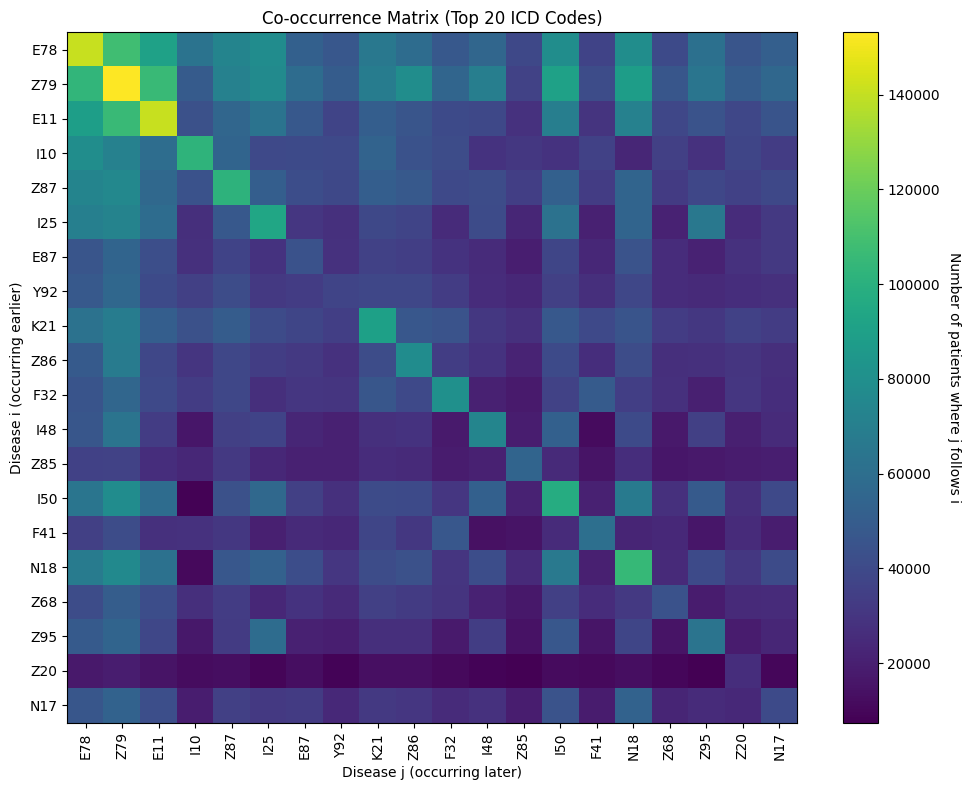

In [9]:
topk      = df['icd_code'].value_counts().nlargest(20)
top_codes = topk.index.tolist()
idx       = [code_to_idx[c] for c in top_codes]

mat = cooc[np.ix_(idx, idx)]
plt.figure(figsize=(10, 8))
im = plt.imshow(mat, aspect='auto')

# 4. Configure axis tick labels
plt.xticks(range(20), top_codes, rotation=90)
plt.yticks(range(20), top_codes)

# 5. Axis labels and title in English
plt.xlabel('Disease j (occurring later)')
plt.ylabel('Disease i (occurring earlier)')
plt.title('Co‑occurrence Matrix (Top 20 ICD Codes)')

# 6. Add colorbar legend indicating patient counts
cbar = plt.colorbar(im)
cbar.set_label('Number of patients where j follows i', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()
